In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import torch.nn as nn
from torch import tensor
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
data = np.load('tiny_nerf_data.npz')
images = torch.tensor(data['images'][0:100])
poses = torch.tensor(data['poses'][0:100])

valImages = torch.tensor(data['images'][100:])
valPoses = torch.tensor(data['poses'][100:])

focalLength = data['focal']
print(data)

poses[12]
print(images.shape)
print(poses.shape)

width = images.shape[1]
height = images.shape[2]
# plt.imshow(images[10])
# for i in range(0, 100):
#     plt.imsave(f"im2/image{i}.png", images[i])
# poses[1]

torch.Size([100, 100, 100, 3])
torch.Size([100, 4, 4])


In [15]:

from Model import NeRfModel

numberOfFor = 6
model  = NeRfModel(numberOfFor, layer_size=200, number_of_layers=4).to(device)

In [76]:
# %matplotlib widget

%matplotlib inline

In [4]:
# returns a two tensors, one with shape [width, height, 3] 
# representing the direction of a ray going through each pixel and another [width, height, 3] 
# representing the starting position of that same ray (all of which are the same) since 
# all rays start out at the origin
def getRays(width, height, focalLength, pose):
    xCoords = torch.arange(width)
    yCoords = torch.arange(height)
    x, y = torch.meshgrid(xCoords, yCoords)
    xShifted = (x - width*0.5)/focalLength # x coords in a [width, height] tensor
    yShifted = (y - height*0.5)/focalLength # y coords in a [width, height] tensor

    z = torch.ones_like(x)  # z coords in a [width, height] tensor

    # match up each element of the 3 tensors (thats why using dim = 2)
    directionVectors = torch.stack((xShifted, -yShifted, -z), dim=2).to(device)
    rotationMatrix = pose[0:3, 0:3]
    # Confustion: I'm not sure why the following line doesn't work
    # rotatedDirections = torch.matmul(directionVectors, rotationMatrix)
    # The paper does it the following way and that seems to give the excepcted reuslts
    rotatedDirections = torch.sum(directionVectors.unsqueeze(2)*rotationMatrix, dim=-1)


    origin =  pose[:3, 3]

    # all the rays have the same origin
    originTensor =  torch.broadcast_to(origin, rotatedDirections.shape)
    return rotatedDirections, originTensor



# dirs, pos = getRaysInBatch(width, height, focalLength, poses[0:5].to(device))
# dirs, pos = getRays(width, height, focalLength, poses[46].to(device))
# print(dirs[0][0])
# print(pos[0][0])
# print(dirs.shape, pos.shape)
# print(dirs[0][0], pos[0][0])


In [78]:

# # def getRaysInBatch(width, height, focalLength, poses):
#     xCoords = torch.arange(width)
#     yCoords = torch.arange(height)
#     x, y = torch.meshgrid(xCoords, yCoords)

#     xShifted = (x - width*0.5)/focalLength # x coords in a [width, height] tensor

#     yShifted = (y - height*0.5)/focalLength # y coords in a [width, height] tensor

#     z = torch.ones_like(x)  # z coords in a [width, height] tensor

#     # match up each element of the 3 tensors (thats why using dim = 2)
#     directionVectors = torch.stack((xShifted, yShifted, z), dim=2).unsqueeze(0).to(device)
#     rotationMatrix = poses[:, 0:3, 0:3] # hase shape (batchSize, 3, 3)

#     # have a bunch of directionVectors, shaped (width, height, 3)
#     # have a bunch of rotationMatricies, shaped (batchSize, 3, 3)
#     # goal is to have a tensor t shaped (batchSize, width, height,  3)
#     # where t[i][x][y] = rotationMatrix[i]@directionVecotors[x][y]

#     # flatten the direction vectors to (1, width*height, 3)
#     directionVectors = directionVectors.view(width*height, 3).unsqueeze(0)

#     # print(directionVectors.shape)

#     print(directionVectors.shape)
#     print(rotationMatrix.shape)

#     # rotationMatrix has shape (batchSize, 3, 3)
#     rotatedDirections = torch.matmul(rotationMatrix, directionVectors)
#     print(rotatedDirections.shape)

#     # Goal: [5, 100, 100, 3]

#     origin =  poses[:, :3, 2]
#     # all the rays have the same origin
#     originTensor =  torch.broadcast_to(origin, rotatedDirections.shape)
#     return rotatedDirections, originTensor

0.005

/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


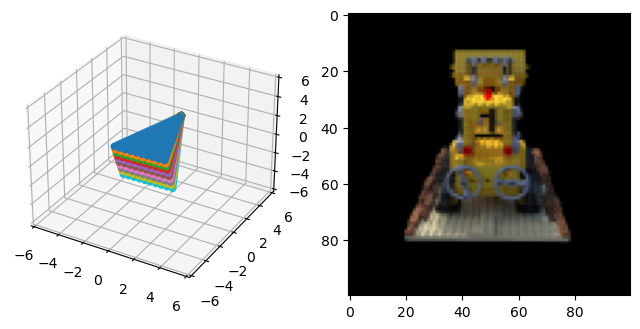

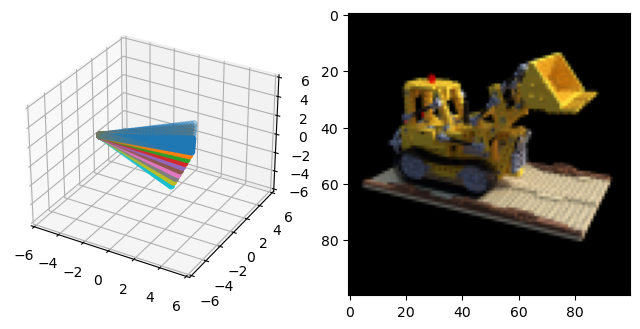

In [5]:
import matplotlib


%matplotlib inline

# matplotlib.use('WebAgg')


numberOfSamples = 128
far = 6
distanceBetweenSamples = far / numberOfSamples

def get_rays_with_samples(pose):
  dirs, pos = getRays(width, height, focalLength, pose)

  # dirs = (width, height, 3)
  # t = (numberOfSamples)
  # goal = (width, height, numberOfSamples, 3)
  # where goal[x][y][i] = dirs[x][y] * t[i]
  t = torch.linspace(0, far, numberOfSamples).reshape(1, 1, numberOfSamples, 1).to(device)

  # dirs has shape (width, height, 3) right now (a direction for every pixel)
  # We want to instead have a list of numberOfSamples for each pixel, so (width, height, numberOfSamples, 3)
  dirs = dirs.reshape(width, height, 1, 3)
  pos = pos.reshape(width, height, 1, 3)
  z = pos + t*dirs
  z = z.to(device)
  return z

# far = 2
def visulize_3D_rays(index, poseNumber):
    fig = plt.figure(figsize=(8,16))
    # fig, axes = plt.subplots(nrows=1, ncols=2)
    ax = fig.add_subplot(1, 2, 1, projection="3d")
    # axes[0].proje
    # f, axisArr = fig.subplots(2, 2)
    # f, axarr = plt.subplots(2,2)
    # print(axes)
    rays = get_rays_with_samples(poseNumber)
    with torch.no_grad():
        rays = rays.cpu()
        for i in range(0, width, 10):
            for j in range(0, height, 10):
                step = 1
                ray = rays[i][j][::step]
                ax.scatter(ray[:, 0], ray[:,1], ray[:, 2])
        ax.set_xlim3d([-far, far])
        ax.set_ylim3d([-far, far])
        ax.set_zlim3d([-far, far])
        ax.set_autoscale_on(False)
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.imshow(images[index])
    # plt.savefig(f"./im1/{index}.png")
    # plt.close()
# visulize_3D_rays(8, poses[8].to(device))
# for i in range(0, 100):
#   visulize_3D_rays(i, poses[i].to(device))
# print(poses[46])
# print(poses[50])
# visulize_3D_rays(46, poses[46].to(device))
visulize_3D_rays(0, poses[0].to(device))
visulize_3D_rays(2, poses[2].to(device))
# visulize_3D_rays(7, poses[7].to(device))
# # print(poses[20])
# get_rays_with_samples(poses[0].to(device)).shape


In [6]:
import gc
import math
# numberOfFor = 1
def get_model_at_each_sample_point(rays):
    #rays is (width, height, numberOfSampels, 3), we want to turn the 3 into 15 by appling foruir feature vectors
    raysBackup = torch.clone(rays)
    rays = rays.reshape(width, height, numberOfSamples, 1, 3, 1).expand(width, height, numberOfSamples, 2, 3, 1)
    twos = torch.tensor(2).repeat(width, height, numberOfSamples, 2, 3, numberOfFor) # 2 since one for sin one for cos
    twos[:, :, :, :, 0] = 1
    twos = torch.cumprod(twos, dim=4).to(device)
    # print(twos[0][0][0])
    # Twos is a (3, numberOfFor+, 21) shaped where each row is [1, 2, 4, 8, ...]
    # print(rays[0][0][0])
    encoding = rays*twos
    # print(encoding[0][0][0])
    encoding[:, :, :, 0] = torch.sin(encoding[:, :, :, 0])
    encoding[:, :, :, 1] = torch.cos(encoding[:, :, :, 1])
    encoding = torch.flatten(encoding, start_dim=3, end_dim=5)

    # add non fourer as well (rays backup is just the normal xyz coords)
    # print(raysBackup[0][0][0])
    encoding = torch.concat((raysBackup, encoding), dim=3)
    # print(encoding[0][0][0])

    return model(encoding)
    

def get_image(pose):
  # gc.collect()
  # torch.cuda.empty_cache()
  rays = get_rays_with_samples(pose)
  return get_image_with_rays(rays)

def get_image_with_rays(rays):
  # current (width, height, numberOfSamples, 4)
  out = get_model_at_each_sample_point(rays)
  # model_out = (width, height, numberOfSamples, 4), where r is rgb + d
  deltaI = tensor(distanceBetweenSamples)

  # Goes from out = (width,height, numberOfSamples, 4) to C = (width, height, 3)

  # The first two dimenstions are width and height
  Ti = torch.cumprod(torch.exp(-out[:, : , :, 3]*deltaI), dim = 2)
  Ti = Ti.reshape(width, height, numberOfSamples, 1)
  # print(Ti.shape)

  aboservedAmounts = (1- torch.exp(-out[:, :, :, 3]*deltaI)).reshape((width, height, numberOfSamples, 1))
  colorI = out[:, :, :, 0:3]

  # Sum along the ray (the first two dimenensions are the width and height)
  C = torch.sum(Ti*aboservedAmounts * colorI, dim = 2)
  return C

def f():
  with torch.no_grad():
    get_image(poses[0].to(device))
f()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


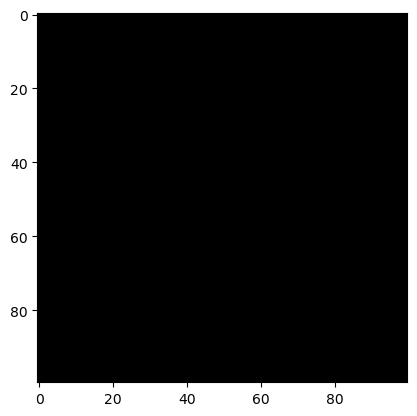

In [7]:
with torch.no_grad():
        pose = poses[12].to(device)
        im = get_image(pose).cpu()
        plt.imshow(im)

In [8]:
from torch.utils.data import Dataset, DataLoader

class NerfDataSet(Dataset):
	def __init__(self, poses, images):
		assert(len(poses) == len(images))

		self.poses = poses
		self.images = images

	def __len__(self) -> int:
		return len(self.poses)

	def __getitem__(self, index):
		return self.poses[index], self.images[index]

dataSet = NerfDataSet(poses[0:10], images[0:10])
dataLoader = DataLoader(dataset=dataSet, batch_size=4, shuffle=True )

Epoch [2/10000], Loss: 1.462047804147005:   0%|          | 2/10000 [00:04<6:10:44,  2.22s/it] 


KeyboardInterrupt: 

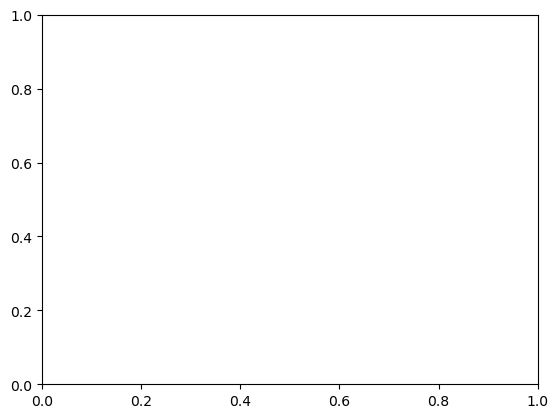

In [9]:
epochs = 10000
from tqdm import tqdm
from IPython.display import clear_output
def loss_fn(output, target):
		loss = torch.mean((output - target)**2)
		return loss

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

pbar = tqdm(range(epochs))
# pbar = range(epochs)

image_display = None

fig = plt.figure()
ax = fig.gca()
i = 0
loss = 0


pose = poses[3]
# image = images[3]
# pose = pose.to(device)
# rays = get_rays_with_samples(pose)

torch.cuda.empty_cache()
poseToRays = {}
torch.cuda.empty_cache()

for epoch in pbar: 
    epoch_loss = 0
    torch.cuda.empty_cache()

    for (pose_batch, image_batch) in dataLoader:
        pose_batch = pose_batch.to(device)
        image_batch = image_batch.to(device)
        for (pose, image) in zip(pose_batch, image_batch):
            i += 1
            # if pose not in poseToRays:
            #     pose = pose.to(device)
                # poseToRays[pose] = get_rays_with_samples(pose)

            # rays = poseToRays[pose]
            rays = get_rays_with_samples(pose)
            pred_image = get_image_with_rays(rays)

            image = image.to(device)
            loss += loss_fn(pred_image, image)
            epoch_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # pbar.set_description( f"{i}: Loss is {loss}")
        loss = 0

        if(i % 100 == 0):
            with torch.no_grad():
                valLoss = 0
                for pose, image in zip(valPoses, valImages):
                    pose = pose.to(device)
                    rays = get_rays_with_samples(pose)
                    pred_image = get_image_with_rays(rays)

                    image = image.to(device)
                    valLoss += loss_fn(pred_image, image)
                    

                
                clear_output()
                print("Validation loss is:", valLoss)

                plt.close()
                f, axarr = plt.subplots(1,2)
                axarr[0].imshow(pred_image.cpu())
                axarr[1].imshow(image.cpu())
                plt.show()

    pbar.set_description(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss}")
    # torch.save(model.state_dict(), "./fixedModel.pkl")
    
    if( i >= 2000):
        i = 0
        



In [ ]:
# torch.save(model.state_dict(), "./basic_model.pkl")

In [19]:
model.load_state_dict(torch.load("./model.pkl"))


<All keys matched successfully>

In [20]:
poses[7]

tensor([[ 0.9045,  0.4252, -0.0322, -0.1298],
        [-0.4265,  0.9019, -0.0683, -0.2753],
        [ 0.0000,  0.0755,  0.9971,  4.0196],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])

tensor([[-9.9990e-01,  4.1922e-03, -1.3346e-02, -5.3798e-02],
        [-1.3989e-02, -2.9966e-01,  9.5394e-01,  3.8455e+00],
        [-4.6566e-10,  9.5404e-01,  2.9969e-01,  1.2081e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])


FloatSlider(value=0.0, continuous_update=False, description='x', max=5.0, min=-5.0, step=0.01)

FloatSlider(value=0.0, continuous_update=False, description='y', max=5.0, min=-5.0, step=0.01)

FloatSlider(value=0.0, continuous_update=False, description='z', max=5.0, min=-5.0, step=0.01)

FloatSlider(value=0.0, continuous_update=False, description='xrot', max=360.0, step=1.0)

FloatSlider(value=0.0, continuous_update=False, description='yrot', max=360.0, step=1.0)

FloatSlider(value=0.0, continuous_update=False, description='zrot', max=360.0, step=1.0)

Button(description='Update', style=ButtonStyle())

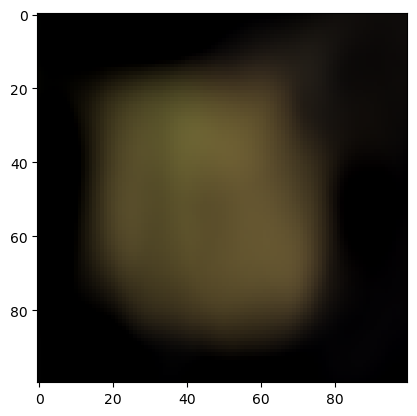

In [21]:
from ipywidgets import interactive, widgets
from IPython.display import display


def translation(x, y, z):
    return tensor([
              [1, 0 ,0, x],
              [0, 1, 0, y],
              [0, 0, 1, z],
              [0, 0, 0, 1]
              ], dtype=torch.float)

def xRotation(theta):
    return tensor(
        [
              [1, 0 ,0, 0],
              [0, math.cos(theta), -math.sin(theta), 0],
              [0, math.sin(theta), math.cos(theta), 0],
              [0, 0, 0, 1]
        ]
    )

def yRotation(theta):
    return tensor(
        [
              [math.cos(theta), 0 ,math.sin(theta), 0],
              [0, 1, 0, 0],
              [-math.sin(theta), 0, math.cos(theta), 0],
              [0, 0, 0, 1]
        ]
    )

def zRotation(theta):
    return tensor(
        [
              [math.cos(theta), -math.sin(theta) ,0, 0],
              [math.sin(theta), math.cos(theta), 0, 0],
              [0, 0, 1, 0],
              [0, 0, 0, 1]
        ]
    )

def getPoseFromCoords(x, y, z, xrot, yrot, zrot):
    toRad = lambda x : x * 2 * math.pi / 360
    pose = translation(x, y, z)
    pose = torch.matmul(xRotation(toRad(xrot)), pose)
    pose = torch.matmul(yRotation(toRad(yrot)), pose)
    pose = torch.matmul(zRotation(toRad(zrot)), pose)

    pose = poses[0] + tensor([[0,0,0,x], [0,0,0,y], [0,0,0,y], [0,0,0,0]])
    return pose

sliderNames = ["x", "y", "z", "xrot", "yrot", "zrot"]
sliders = {}
for sliderName in sliderNames:
    rot = False
    if "rot" in sliderName:
        rot = True

    slider = widgets.FloatSlider(
        value=0,
        min= 0 if rot else -5,
        max=360 if rot else 5.0 ,
        step=1 if rot else 0.01,
        description=sliderName,
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='.2f',
    )
    sliders[sliderName] = slider

allSliders = sliders.values()

button = widgets.Button(description="Update")

def on_button_clicked(_):
    pose = getPoseFromCoords(*[sliders[sliderName].value for sliderName in sliderNames])
    with torch.no_grad():
        image  = get_image(pose.to(device))
        image = torch.clip(image, 0, 1)
        clear_output()
        print(pose)
        plt.imshow(image.cpu())
    display(*sliders.values(), button)
button.on_click(on_button_clicked)
on_button_clicked(None)

In [11]:
poses[19]

tensor([[ 0.5655, -0.2501,  0.7859,  3.1680],
        [ 0.8247,  0.1715, -0.5389, -2.1723],
        [ 0.0000,  0.9529,  0.3033,  1.2227],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])

In [12]:
getPoseFromSphericalCoords(1,0,1)

NameError: name 'getPoseFromSphericalCoords' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6


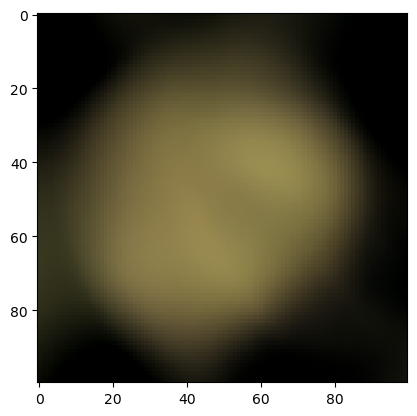

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7


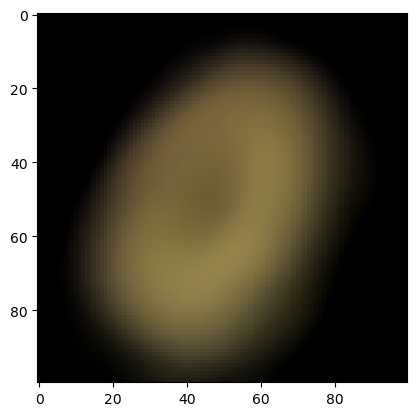

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8


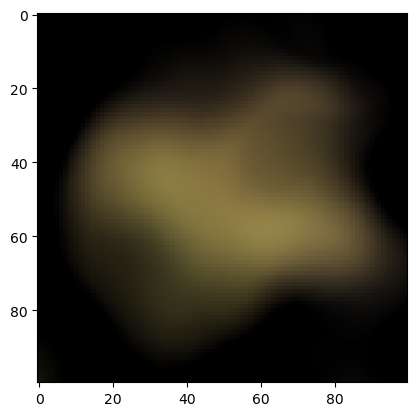

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9


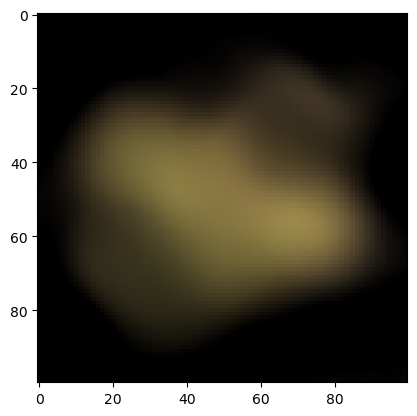

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10


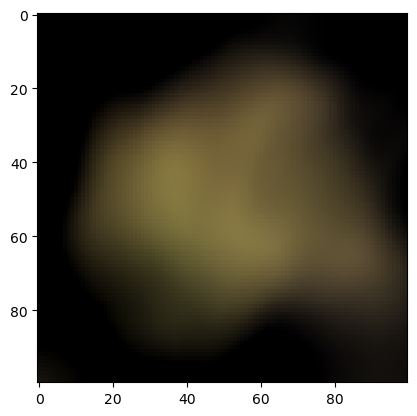

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


11


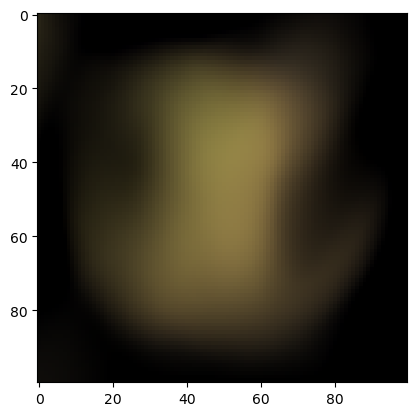

In [22]:
with torch.no_grad():
     for i in range(6, 12):
         image  = get_image(poses[i].to(device))
         plt.imshow(image.cpu())
         print(i)
         plt.show()